In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numba as nb
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from numbalsoda import lsoda_sig, lsoda
from numba import types
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import optoPi as op
import scienceplots
plt.style.use('science')

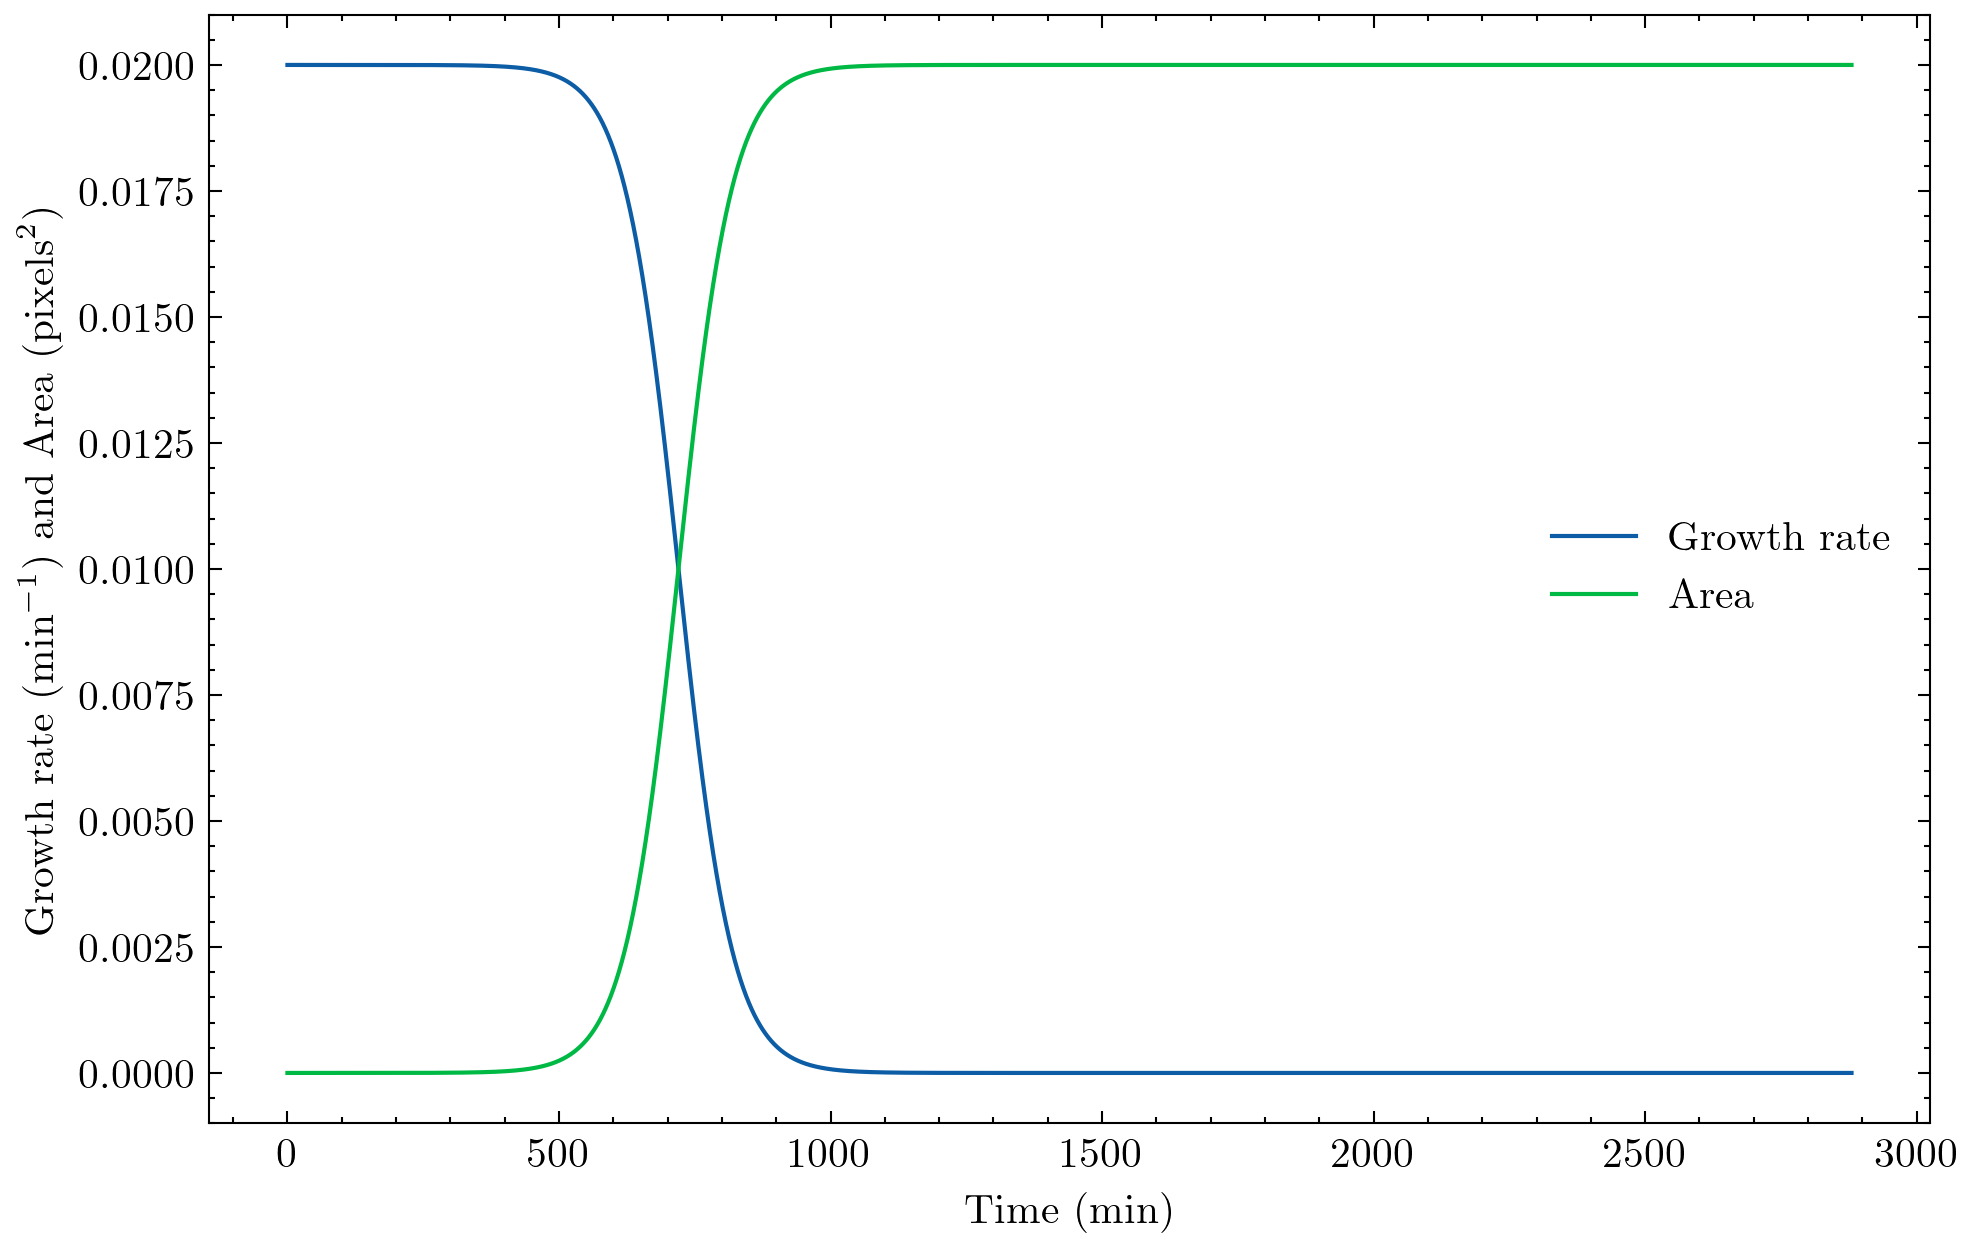

In [10]:
# Test the growth of a population of cells

# Define the timepoints to evaluate the model
# Gompertz model
t = np.linspace(0, 60*48, 60*48*10)
mu_max = 0.02 # min^-1
A_max = 0.02

plt.figure(figsize=(7.4, 4.8), dpi=300)
plt.plot(t, op.muFunction(t, mu_max, 12*60), label='Growth rate')
plt.plot(t, op.areaFunction(t, A_max, mu_max, 12*60), label='Area')
plt.xlabel('Time (min)')
plt.ylabel(r'Growth rate ($\text{min}^{-1}$) and Area ($\text{pixels}^2$)')
plt.legend()
plt.show()

In [16]:
def optoControl(t, schedule_times, schedule_R, schedule_G):
    '''
    To create the optogenetic control signals for a single time point

    Parameters:
    ----------
    t: float
      Current time point

    schedule_times: list
      List with upper limits of each module in the same units as t

    schedule_R: list
      List with the power intensity of R channel in each module - power [0,1]

    schedule_G: list
      List with the power intensity of G channel in each module - power [0,1]

    Return:
    --------
    (R_signal, G_signal): tuple
      Tuple with the control signals for the 'R' and 'G' channels
    '''
    # Find the current time module
    step = next((i for i, time_limit in enumerate(schedule_times) if t < time_limit), len(schedule_times)-1)

    # Get the power intensities for 'R' and 'G' channels
    R_signal = schedule_R[step]
    G_signal = schedule_G[step]

    return (R_signal, G_signal)

In [17]:
t_final = 48   # in hours
tlh = [24,t_final]    # time limits in hours
tlm = [i * 60 for i in tlh]  # time limits in minutes
t_span = np.linspace(0, t_final*60, t_final*60*10)  # in minutes

schedule_times = tlm
schedule_R = [0, 1]
schedule_G = [1, 0]

In [20]:
# [TFtot] at steady state = k_tx*k_tl/(d_m + d_protein + mu(t))
# d[TFon]/dt = I_G(t)*K_ON*([TFtot](t) - [TFon]) - (I_R(t)*K_OFF + BASAL_K_OFF)*[TFon] - (d_protein + mu(t))*[TFon]
# d[mRNA_GFP]/dt = beta_0 + (k_tx - beta_0)*([TFon]/([TFon] + KD_TFon)) - d_m*mRNA_GFP
# d[GFP_OFF]/dt = k_tl*mRNA_GFP - (d_protein + mu(t))*GFP_OFF
# GFP takes time to mature, so we need to account for the maturation time
# d[GFP_ON]/dt = k_matur*GFP_OFF - (d_protein + mu(t))*GFP_ON

def TFtot_dilution(mu):
    return k_tx*k_tl/(d_m * (d_p + mu))

# Define the parameters
k_tx = 30.323 # min^-1
k_tl = 0.37 # min^-1
d_m = 0.042 # min^-1
d_p = 0.007
k_matur = 0.1 # min^-1
KD_TFon = 1267 # nM
K_ON = 0.15 # nM^-1 min^-1
K_OFF = 0.025 # min^-1
BASAL_K_OFF = 0.0025 # min^-1
beta_0 = 0.015 # min^-1

# Define the parameters for the mu function
mu_max = 2e-2 # min^-1
t_50 = 14*60 # min

# Define the initial conditions
TFon_0 = 0 # nM
mRNA_GFP_0 = 0 # nM
GFP_OFF_0 = 0 # nM
GFP_ON_0 = 0 # nM

# Define the model
def model(t, y, schedule_times, schedule_G, schedule_R, k_tx, k_tl, d_m, d_p, k_matur, KD_TFon, K_ON, K_OFF, BASAL_K_OFF, beta_0, mu_max, t_50):
    TFon, mRNA_GFP, GFP_OFF, GFP_ON = y
    R_signal, G_signal = optoControl(t, schedule_times, schedule_R, schedule_G)
    dTFon = G_signal*K_ON*(TFtot_dilution(op.muFunction(t, mu_max, t_50)) - TFon) - (R_signal*K_OFF + BASAL_K_OFF)*TFon - (5*d_p + op.muFunction(t, mu_max, t_50))*TFon
    dmRNA_GFP = beta_0 + (k_tx - beta_0)*(TFon**2/(TFon**2 + KD_TFon**2)) - d_m*mRNA_GFP
    dGFP_OFF = k_tl*mRNA_GFP - (d_p + op.muFunction(t, mu_max, t_50))*GFP_OFF
    dGFP_ON = k_matur*GFP_OFF - (d_p + op.muFunction(t, mu_max, t_50))*GFP_ON
    return np.array([dTFon, dmRNA_GFP, dGFP_OFF, dGFP_ON])

# Define the initial conditions
y0 = np.array([TFon_0, mRNA_GFP_0, GFP_OFF_0, GFP_ON_0])

# Numerically solve the model using scipy.integrate.solve_ivp
sol = sp.integrate.solve_ivp(model, [0, t_final*60], y0, args=(schedule_times, schedule_G, schedule_R, k_tx, k_tl, d_m, d_p, k_matur, KD_TFon, K_ON, K_OFF, BASAL_K_OFF, beta_0, mu_max, t_50), t_eval=t_span, method='BDF', rtol=1e-8, atol=1e-8)

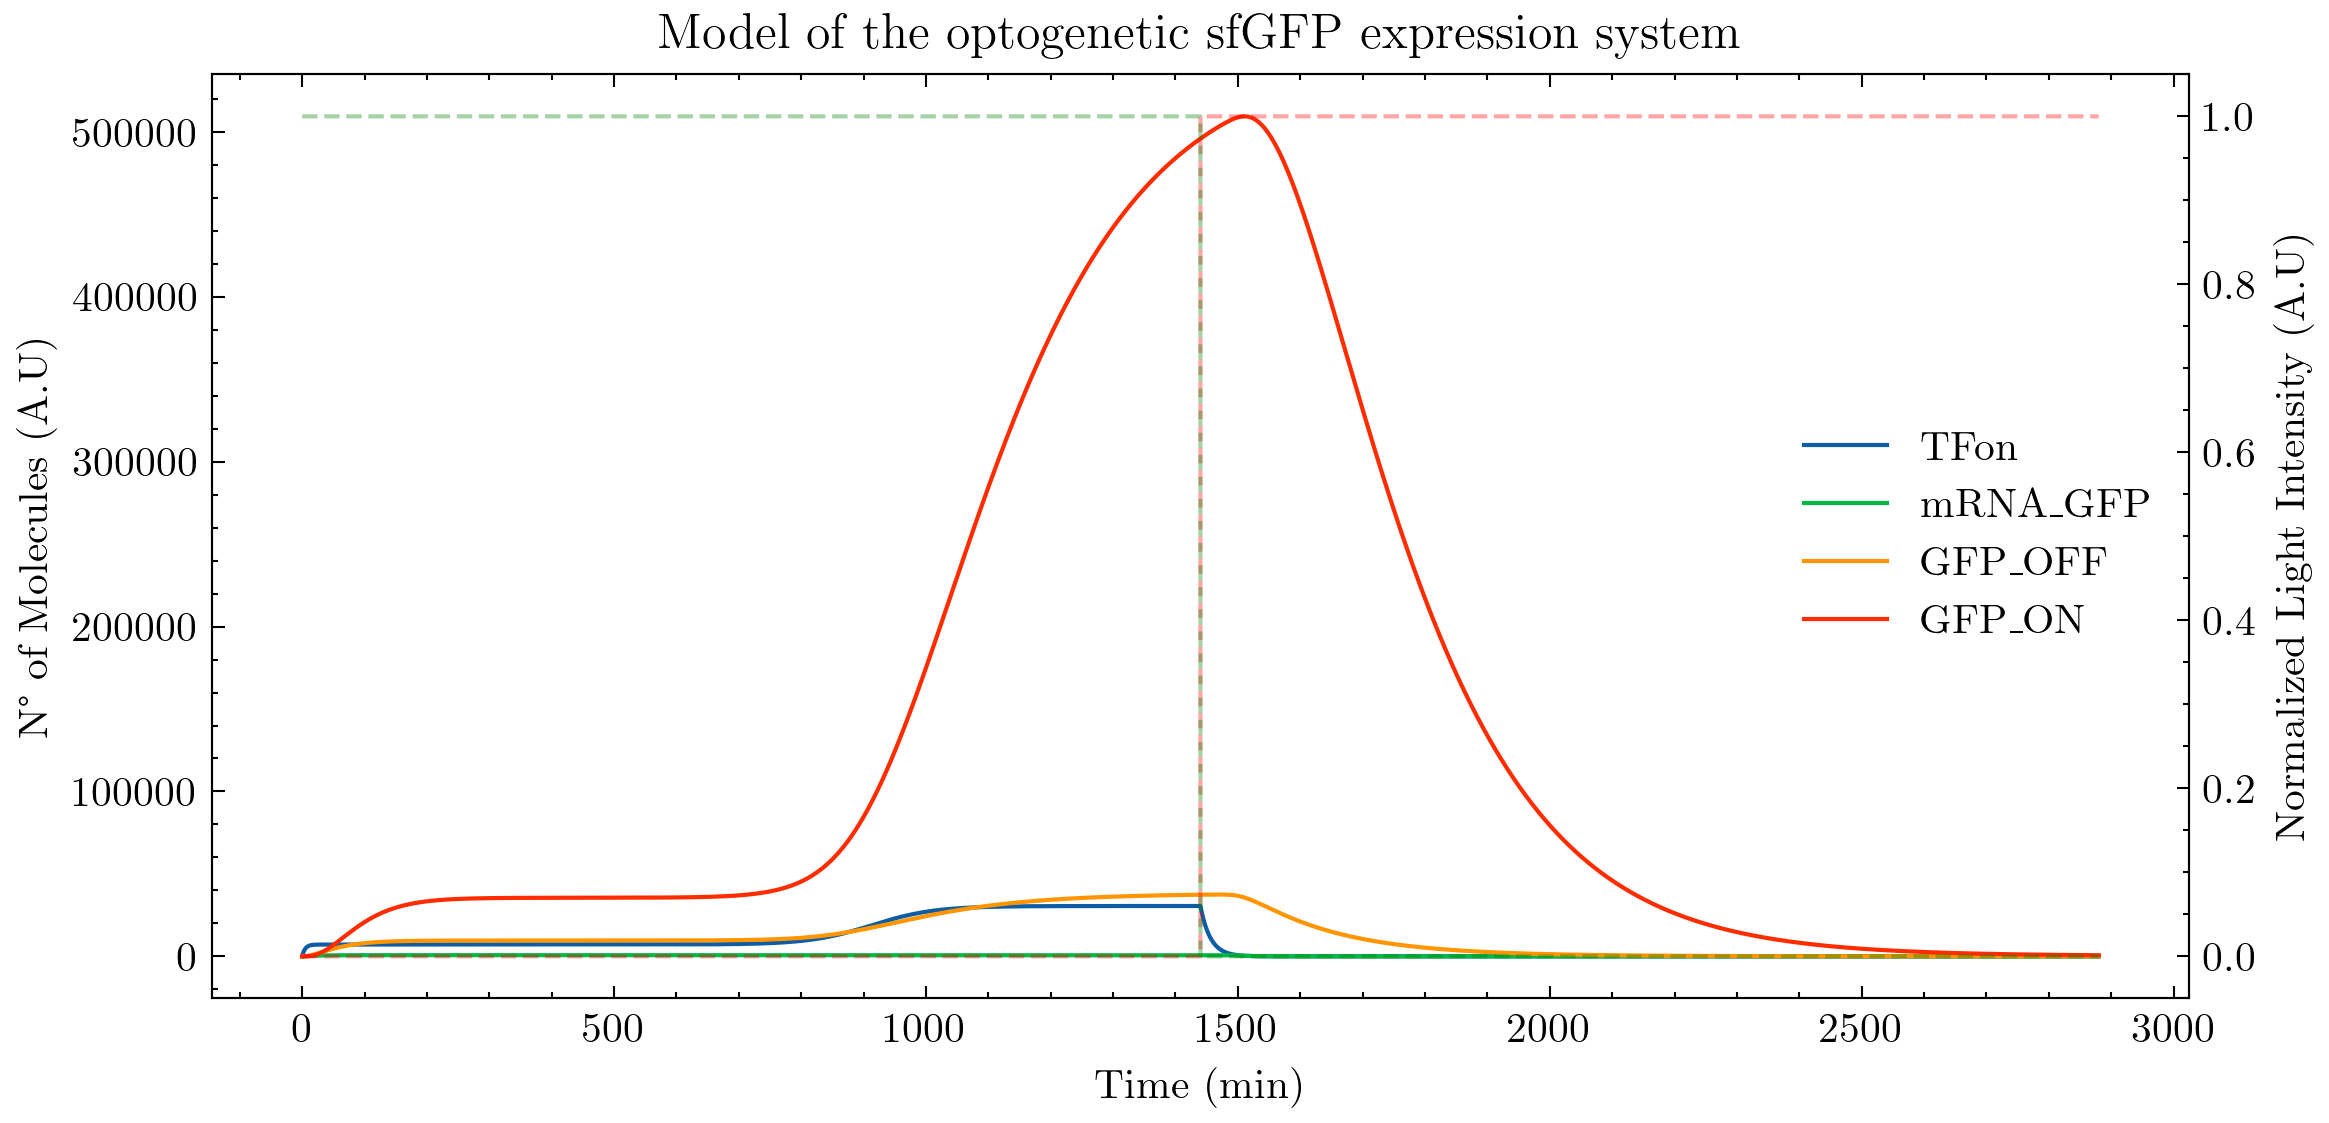

In [27]:
# Plot the results using matplotlib
fig, ax = plt.subplots(1, 1, figsize=(8.5, 4), dpi=300)
ax.plot(sol.t, sol.y[0], label='TFon')
ax.plot(sol.t, sol.y[1], label='mRNA_GFP')
ax.plot(sol.t, sol.y[2], label='GFP_OFF')
ax.plot(sol.t, sol.y[3], label='GFP_ON')
# Also plot the control signals in a separate y axis
ax2 = ax.twinx()
R_signals = []
G_signals = []
for t in sol.t:
    R_signal, G_signal = optoControl(t, schedule_times, schedule_R, schedule_G)
    R_signals.append(R_signal)
    G_signals.append(G_signal)
ax2.plot(sol.t, R_signals, label='R_signal', color='r', linestyle='--', alpha=0.35)
ax2.plot(sol.t, G_signals, label='G_signal', color='g', linestyle='--', alpha=0.35)
# Set the labels
ax.set_xlabel('Time (min)')
ax.set_ylabel('N° of Molecules (A.U)')
ax2.set_ylabel('Normalized Light Intensity (A.U)')
# Set the legend at the center right of the plot
ax.legend(loc='center right')
# Set the first y axis to log scale
#ax.set_yscale('log')
#ax.set_ylim(1e-6, 1e6)
# Set a title
plt.title('Model of the optogenetic sfGFP expression system')
plt.show()

## Updated Opto Model

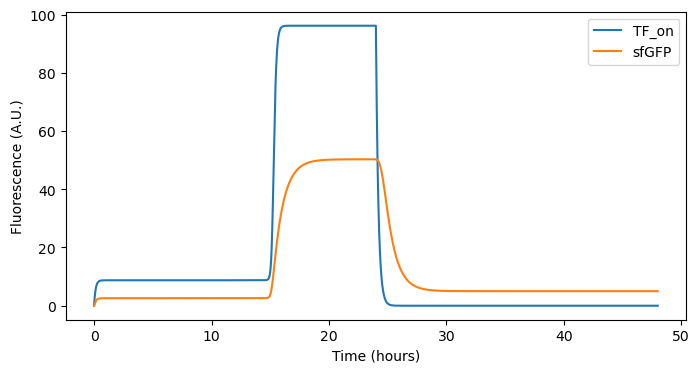

In [12]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def optoControl(t, schedule_times, schedule_R, schedule_G):
    """
    Create the optogenetic control signals for a single time point.
    
    Parameters:
    - t: current time point
    - schedule_times: list with upper limits of each module in the same units as t
    - schedule_R: list with the power intensity of R channel in each module - power [0,1]
    - schedule_G: list with the power intensity of G channel in each module - power [0,1]
    
    Returns:
    - (R_signal, G_signal): tuple with the control signals for the 'R' and 'G' channels
    """
    step = next((i for i, time_limit in enumerate(schedule_times) if t < time_limit), len(schedule_times)-1)
    R_signal = schedule_R[step]
    G_signal = schedule_G[step]
    return (R_signal, G_signal)

def optogenetic_model(y, t, params):
    """
    Optogenetic model ODEs.
    
    Parameters:
    - y: list of state variables [TF_on, sfGFP]
    - t: time
    - params: dictionary of model parameters
    
    Returns:
    - dydt: list of ODEs
    """
    TF_on, sfGFP = y
    
    # Extract parameters from the dictionary
    k_on, k_off, k_off_base, d_p, K_d, alpha_fl, alpha_prod, A_max, mu_max, t_50 = params['k_on'], params['k_off'], params['k_off_base'], params['d_p'], params['K_d'], params['alpha_fl'], params['alpha_prod'], params['A_max'], params['mu_max'], params['t_50']
    
    # Get the optogenetic control signals for the current time point
    I_red, I_green = optoControl(t, schedule_times, schedule_R, schedule_G)
    
    # Calculate the time-dependent dilution rate
    mu = mu_max / (1 + np.exp(mu_max * (t - t_50)))
    
    # Calculate the steady-state total transcription factor concentration
    TF_tot_ss = params['ktx'] * params['ktr'] / (params['dm'] * (d_p + mu))
    
    # ODEs
    dTF_on_dt = I_green * k_on * (TF_tot_ss - TF_on) - (I_red * k_off + k_off_base + d_p) * TF_on
    dsfGFP_dt = alpha_fl * (params['beta_0_tilde'] + params['beta_1_tilde'] * (TF_on / (K_d + TF_on))) - (d_p + mu) * sfGFP
    
    return [dTF_on_dt, dsfGFP_dt]

# Define the parameter values
params = {
    'k_on': 0.1,
    'k_off': 0.05,
    'k_off_base': 0.01,
    'd_p': 0.02,
    'K_d': 10.0,
    'alpha_fl': 1.0,
    'alpha_prod': 5.0,
    'A_max': 100.0,
    'mu_max': 0.2,
    't_50': 15.0*60,
    'ktx': 0.5,
    'ktr': 0.5,
    'dm': 0.1,
    'beta_0_tilde': 0.1,
    'beta_1_tilde': 1.0
}

# Initial conditions
TF_on_0 = 0.0
sfGFP_0 = 0.0
y0 = [TF_on_0, sfGFP_0]

# Time points
t_final = 48   # in hours
tlh = [24, t_final]    # time limits in hours
tlm = [i * 60 for i in tlh]  # time limits in minutes
t_span = np.linspace(0, t_final*60, t_final*60*10)  # in minutes

# Optogenetic control schedule
schedule_times = tlm
schedule_R = [0, 1]
schedule_G = [1, 0]

# Solve the ODEs
sol = odeint(optogenetic_model, y0, t_span, args=(params,))

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(t_span/60, sol[:, 0], label='TF_on')
plt.plot(t_span/60, sol[:, 1], label='sfGFP')
plt.xlabel('Time (hours)')
plt.ylabel('Fluorescence (A.U.)')
plt.legend()
plt.show()

## Attempt 2.0

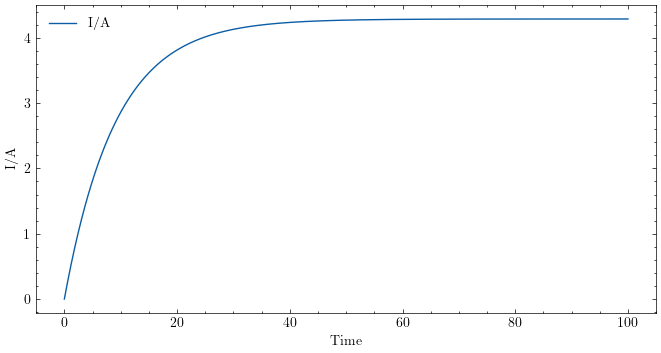

In [37]:
# Define the differential equation for d(I/A)/dt based on equation 28
def dIAdt(I_over_A, t, tilde_beta_0, tilde_beta_1, tilde_K_D, k_on, k_off, k_off_base, d_p, mu):
    numerator = (I_green * k_on)
    denominator = (I_green * k_on + I_red * k_off + k_off_base + d_p)
    TF_on = numerator / denominator
    production_term = tilde_beta_0 + tilde_beta_1 * (TF_on / (tilde_K_D + TF_on))
    dilution_and_degradation = d_p * I_over_A + mu * I_over_A
    return production_term - dilution_and_degradation

# Simulate the system (assuming initial conditions and time points are provided)
initial_I_over_A = 0.0  # Initial condition for I/A
time_points = np.linspace(0, 100, 1000)  # Time points for simulation

# Parameters for simulation (these would be based on experimental data or guesses)
tilde_beta_0 = 0.1
tilde_beta_1 = 0.5
tilde_K_D = 0.3
k_on = 1.0
k_off = 0.5
k_off_base = 0.05
d_p = 0.1
mu = 0.01  # Constant dilution rate

# I_green and I_red should be provided based on the experimental setup
I_green = 1.0
I_red = 0.0

# Simulate the system
I_over_A_solution = odeint(dIAdt, initial_I_over_A, time_points, args=(tilde_beta_0, tilde_beta_1, tilde_K_D, k_on, k_off, k_off_base, d_p, mu))

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(time_points, I_over_A_solution, label='I/A')
plt.xlabel('Time')
plt.ylabel('I/A')
plt.legend()
plt.show()

Best-fit parameters:
tilde_beta_0: 0.4681384799506914
tilde_beta_1: 0.5213372918230471
tilde_K_D: 37.51662007522637
k_on: 0.43978432153003005
k_off: 1.0000000000015217
k_off_base: 8.74415848369313
d_p: 0.09946620813703823


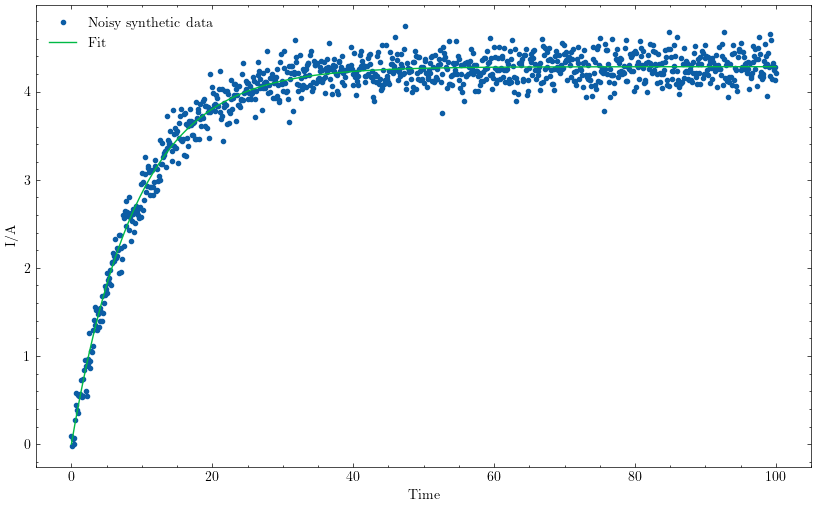

In [40]:
# Define the differential equation for d(I/A)/dt
def dIAdt(I_over_A, t, tilde_beta_0, tilde_beta_1, tilde_K_D, k_on, k_off, k_off_base, d_p, mu):
    TF_on = (I_green * k_on) / (I_green * k_on + I_red * k_off + k_off_base + d_p)
    production_term = tilde_beta_0 + tilde_beta_1 * (TF_on / (tilde_K_D + TF_on))
    return production_term - d_p * I_over_A - mu * I_over_A

# Parameters for generating synthetic data
tilde_beta_0 = 0.1
tilde_beta_1 = 0.5
tilde_K_D = 0.3
k_on = 1.0
k_off = 0.5
k_off_base = 0.05
d_p = 0.1
mu = 0.01  # Constant dilution rate
I_green = 1.0
I_red = 0.0

# Generate synthetic data
time_points = np.linspace(0, 100, 1000)
initial_I_over_A = 0.0
true_solution = odeint(dIAdt, initial_I_over_A, time_points, args=(tilde_beta_0, tilde_beta_1, tilde_K_D, k_on, k_off, k_off_base, d_p, mu))

# Add Gaussian noise to the synthetic data
noise_level = 0.15
noisy_data = true_solution.flatten() + np.random.normal(0, noise_level, size=time_points.shape)

# Define a function to be fitted to the data
def fit_function(t, tilde_beta_0, tilde_beta_1, tilde_K_D, k_on, k_off, k_off_base, d_p):
    solution = odeint(dIAdt, initial_I_over_A, t, args=(tilde_beta_0, tilde_beta_1, tilde_K_D, k_on, k_off, k_off_base, d_p, mu))
    return solution.flatten()

# Fit the model to the noisy synthetic data
# Restrict the parameters to be non-negative
bounds = (0, [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
popt, pcov = curve_fit(fit_function, time_points, noisy_data, bounds=bounds)

# Extract the best-fit parameters
tilde_beta_0_fit, tilde_beta_1_fit, tilde_K_D_fit, k_on_fit, k_off_fit, k_off_base_fit, d_p_fit = popt

# Print the best-fit parameters
print("Best-fit parameters:")
print(f"tilde_beta_0: {tilde_beta_0_fit}")
print(f"tilde_beta_1: {tilde_beta_1_fit}")
print(f"tilde_K_D: {tilde_K_D_fit}")
print(f"k_on: {k_on_fit}")
print(f"k_off: {k_off_fit}")
print(f"k_off_base: {k_off_base_fit}")
print(f"d_p: {d_p_fit}")

# Plot the noisy synthetic data and the fit
plt.figure(figsize=(10, 6))
plt.plot(time_points, noisy_data, 'o', label='Noisy synthetic data', markersize=3)
plt.plot(time_points, fit_function(time_points, *popt), '-', label='Fit')
plt.xlabel('Time')
plt.ylabel('I/A')
plt.legend()
plt.show()

c:\Users\AlejandroAravena\AppData\Local\miniforge3\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Best-fit parameters:
tilde_beta_0: 0.09977678239048315
tilde_beta_1: 0.5037925813135977
tilde_K_D: 0.3188924328347712
k_on: 1.1975767363793919
k_off: 0.5
k_off_base: 9.666653221888081e-05
d_p: 0.09976700135343858


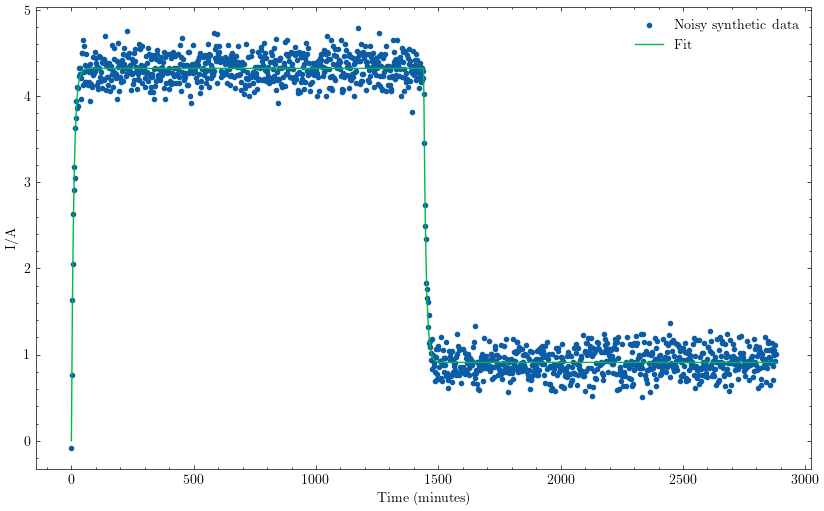

In [44]:
# Define the optogenetic control function
def optoControl(t, schedule_times, schedule_R, schedule_G):
    step = next((i for i, time_limit in enumerate(schedule_times) if t < time_limit), len(schedule_times)-1)
    R_signal = schedule_R[step]
    G_signal = schedule_G[step]
    return (R_signal, G_signal)

# Define the differential equation for d(I/A)/dt
def dIAdt(I_over_A, t, tilde_beta_0, tilde_beta_1, tilde_K_D, k_on, k_off, k_off_base, d_p, mu, schedule_times, schedule_R, schedule_G):
    I_red, I_green = optoControl(t, schedule_times, schedule_R, schedule_G)
    TF_on = (I_green * k_on) / (I_green * k_on + I_red * k_off + k_off_base + d_p)
    production_term = tilde_beta_0 + tilde_beta_1 * (TF_on / (tilde_K_D + TF_on))
    return production_term - d_p * I_over_A - mu * I_over_A

# Parameters for generating synthetic data
tilde_beta_0 = 0.1
tilde_beta_1 = 0.5
tilde_K_D = 0.3
k_on = 1.0
k_off = 0.005
k_off_base = 0.0005
d_p = 0.1
mu = 0.01  # Constant dilution rate

# Optogenetic control schedule
schedule_times = [24 * 60, 48 * 60]  # time limits in minutes
schedule_R = [0, 1]  # Red intensity
schedule_G = [1, 0]  # Green intensity

# Generate synthetic data
time_points = np.linspace(0, 48*60, 48*60//2)  # Time points for simulation in minutes
initial_I_over_A = 0.0
args = (tilde_beta_0, tilde_beta_1, tilde_K_D, k_on, k_off, k_off_base, d_p, mu, schedule_times, schedule_R, schedule_G)
true_solution = odeint(dIAdt, initial_I_over_A, time_points, args=args)

# Add Gaussian noise to the synthetic data
noise_level = 0.15
noisy_data = true_solution.flatten() + np.random.normal(0, noise_level, size=time_points.shape)

# Define a function to be fitted to the data
def fit_function(t, tilde_beta_0, tilde_beta_1, tilde_K_D, k_on, k_off, k_off_base, d_p):
    return odeint(dIAdt, initial_I_over_A, t, args=(tilde_beta_0, tilde_beta_1, tilde_K_D, k_on, k_off, k_off_base, d_p, mu, schedule_times, schedule_R, schedule_G)).flatten()

# Fit the model to the noisy synthetic data
initial_guess = [0.1, 0.5, 0.3, 1.0, 0.5, 0.05, 0.1]
popt, pcov = curve_fit(fit_function, time_points, noisy_data, p0=initial_guess)

# Extract the best-fit parameters
tilde_beta_0_fit, tilde_beta_1_fit, tilde_K_D_fit, k_on_fit, k_off_fit, k_off_base_fit, d_p_fit = popt

# Print the best-fit parameters
print("Best-fit parameters:")
print(f"tilde_beta_0: {tilde_beta_0_fit}")
print(f"tilde_beta_1: {tilde_beta_1_fit}")
print(f"tilde_K_D: {tilde_K_D_fit}")
print(f"k_on: {k_on_fit}")
print(f"k_off: {k_off_fit}")
print(f"k_off_base: {k_off_base_fit}")
print(f"d_p: {d_p_fit}")

# Plot the noisy synthetic data and the fit
plt.figure(figsize=(10, 6))
plt.plot(time_points, noisy_data, 'o', label='Noisy synthetic data', markersize=3)
plt.plot(time_points, fit_function(time_points, *popt), '-', label='Fit')
plt.xlabel('Time (minutes)')
plt.ylabel('I/A')
plt.legend()
plt.show()